In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# from torchvision.models.quantization import models
from torchvision import models

import copy

## Enabling CUDA

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

## Loading Dataset

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
num_classes = 10
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels.shape)
print(labels[1])

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([4])
tensor(6)


In [0]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5 ## denormalizing
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


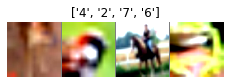

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


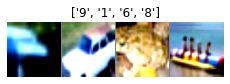

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


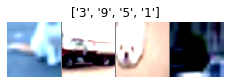

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


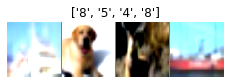

In [0]:
for i in range(4):
  show_batch_images(trainloader)

## Training VGG

In [0]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in model.parameters():
  param.requires_grad = False

in_features = model.classifier[0].in_features

model.classifier = nn.Sequential(
    nn.Linear(in_features, 4096, bias=True),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1000, bias=True),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10, bias=True)
)

for param in model.parameters():
  if param.requires_grad:
    print(param.shape)

In [0]:
for param in model.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([1000, 4096])
torch.Size([1000])
torch.Size([10, 1000])
torch.Size([10])


In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), 0.0001)
epochs = 10

loss_arr = []

for epoch in range(epochs):
  loss_value = 0.0
  for i, data in enumerate(trainloader):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    
    opt.zero_grad()

    loss_val = criterion(outputs, labels)
    loss_val.backward()
    opt.step()

    if i%100 == 1:
      print('epoch :', epoch, ' iteration :', i, ' loss: ', loss_val.item())
    loss_value += loss_val.item()
  loss_arr.append(loss_value/i)



epoch : 0  iteration : 1  loss:  1.4993647336959839
epoch : 0  iteration : 101  loss:  4.124796390533447
epoch : 0  iteration : 201  loss:  0.6865440011024475
epoch : 0  iteration : 301  loss:  1.1066062450408936
epoch : 0  iteration : 401  loss:  0.9314309358596802
epoch : 0  iteration : 501  loss:  1.0824631452560425
epoch : 0  iteration : 601  loss:  0.8906031250953674
epoch : 0  iteration : 701  loss:  0.7609904408454895
epoch : 0  iteration : 801  loss:  1.345536708831787
epoch : 0  iteration : 901  loss:  0.7539348602294922
epoch : 0  iteration : 1001  loss:  1.9128673076629639
epoch : 0  iteration : 1101  loss:  1.6486985683441162
epoch : 0  iteration : 1201  loss:  1.1431183815002441
epoch : 0  iteration : 1301  loss:  0.8565210103988647
epoch : 0  iteration : 1401  loss:  1.3123561143875122
epoch : 0  iteration : 1501  loss:  2.293846607208252
epoch : 0  iteration : 1601  loss:  2.1540377140045166
epoch : 0  iteration : 1701  loss:  1.030517339706421
epoch : 0  iteration : 180

In [0]:
def evaluate(model, criterion, dataloader, num_batches):
  total, correct = 0, 0
  count = 0
  for data in dataloader:
    images, labels = data
    # print(images.shape)
    # print(labels.shape)
    print('iteration i: ', count)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, pred = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
    if count >= num_batches:
      break
    count += 1
  print('Accuracy is %f' % (correct/total) )
  return correct/total

In [0]:
def quantize_evaluate(model, criterion, dataloader, num_batches):
  total, correct = 0, 0
  count = 0
  for data in dataloader:
    images, labels = data
    # print(images.shape)
    # print(labels.shape)
    images = torch.quantize_per_tensor(images, scale=1e-3, zero_point=0, dtype=torch.quint8) ##
    print('iteration i: ', count)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, pred = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
    if count >= num_batches:
      break
    count += 1
  print('Accuracy is %f' % (correct/total) )
  return correct/total

In [0]:
import os 
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [0]:
# Start with simple min/max range estimation and per-tensor quantization of weights
model.qconfig = torch.quantization.default_qconfig
print(model.qconfig)
torch.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n Inverted Residual Block:After observer insertion \n\n', model.features[0])

# Calibrate with the training set
evaluate(model, criterion, trainloader, num_batches=10)
print('Post Training Quantization: Calibration done')

# Convert to quantized model
torch.quantization.convert(model, inplace=True)
print('Post Training Quantization: Convert done')
print('\n Inverted Residual Block: After fusion and quantization, note fused modules: \n\n',model.features[0])

print("Size of model after quantization")
print_size_of_model(model)



In [0]:
print(model)

VGG(
  (features): Sequential(
    (0): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.17031711339950562, zero_point=57, padding=(1, 1))
    (1): QuantizedReLU(inplace=True)
    (2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.2733255922794342, zero_point=66, padding=(1, 1))
    (3): QuantizedReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.5160344243049622, zero_point=69, padding=(1, 1))
    (6): QuantizedReLU(inplace=True)
    (7): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.576509416103363, zero_point=66, padding=(1, 1))
    (8): QuantizedReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.6099780201911926, zero_point=68, padding=(1, 1))
    (11): QuantizedReLU

In [0]:
num_batches = 19
top1 = quantize_evaluate(model, criterion, trainloader, num_batches=10)
print('Evaluation accuracy on %d images, %2.2f'%(num_batches * batch_size, top1))

iteration i:  0
iteration i:  1
iteration i:  2
iteration i:  3
iteration i:  4
iteration i:  5
iteration i:  6
iteration i:  7
iteration i:  8
iteration i:  9
iteration i:  10
Accuracy is 0.000000
Evaluation accuracy on 76 images, 0.00
